# Jupiter notebook for the tenth seminar

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange, tqdm
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8,5
%matplotlib inline

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
print("Version of tensorflow:",tf.__version__)
import sys
from IPython.display import clear_output

Version of tensorflow: 2.7.0


## Deep CNN to classify images

In [ ]:
# Download dataset
data_train = tfds.load(name="fashion_mnist", split="train").prefetch(60000).cache()
data_test  = tfds.load(name="fashion_mnist", split="test" ).prefetch(10000).cache()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteQ4E2LU/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteQ4E2LU/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


[['Pullover' 'Trouser' 'Bag' 'Coat' 'Trouser']
 ['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top' 'Pullover']
 ['Shirt' 'Ankle boot' 'T-shirt/top' 'Sneaker' 'Sandal']
 ['Coat' 'T-shirt/top' 'Trouser' 'Bag' 'T-shirt/top']
 ['Coat' 'Pullover' 'Shirt' 'Sneaker' 'T-shirt/top']]


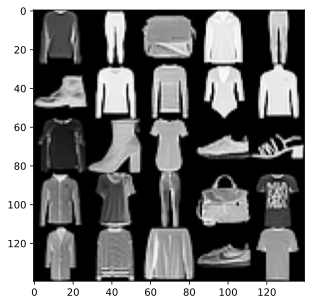

In [ ]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top','Trouser','Pullover','Dress','Coat',
                        'Sandal','Shirt','Sneaker','Bag','Ankle boot'])

# Get a single data batch of 25 images
sample_data = next(iter(data_train.batch(25)))
sample_images = sample_data['image']
sample_labels = sample_data['label']

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
plt.imshow(
    sample_images.numpy().reshape(5, 5, 28, 28).transpose((0, 2, 1, 3)).reshape(140, 140),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(5, 5)])

In [ ]:
# CNN to classify images
def build_model(use_batchnorm=False, dropout_rate=0.):
  """
  If use_batchnorm is True, add a batchnorm layer to **every** convolution and
  dense layer (except for the output one).
  If dropout_rate > 0, add a dropout layer with `rate=dropout_rate` to **every**
  convolution and dense layer (except for the output one).
  """
  layers = []
  filters_sequence = [5, 20, 100, 200]
  kernel_sequence  = [3, 2, 3, 1]
  dense_sequence   = [128, 64, 32]

  for i in range(4):
    layers.append(tf.keras.layers.Conv2D(filters=filters_sequence[i], kernel_size=kernel_sequence[i]))
    if use_batchnorm:      layers.append(tf.keras.layers.BatchNormalization(axis=3))
    layers.append(tf.keras.layers.Activation("elu"))
    if (dropout_rate > 0): layers.append(tf.keras.layers.Dropout(rate=dropout_rate))
    layers.append(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

  layers.append(tf.keras.layers.Reshape(target_shape=(200,), input_shape=(1,1,200)))
  for i in range(3):
    layers.append(tf.keras.layers.Dense(dense_sequence[i]))
    if use_batchnorm:      layers.append(tf.keras.layers.BatchNormalization(axis=1))
    layers.append(tf.keras.layers.Activation("relu"))
    if (dropout_rate > 0): layers.append(tf.keras.layers.Dropout(rate=dropout_rate))

  layers.append(tf.keras.layers.Dense(10))

  model = tf.keras.Sequential(layers)
  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
# Differnet configs
configs = [
  dict(use_batchnorm=False, dropout_rate=0),
  dict(use_batchnorm=False, dropout_rate=0.01),
  dict(use_batchnorm=False, dropout_rate=0.05),
  dict(use_batchnorm=False, dropout_rate=0.5),
  dict(use_batchnorm=True, dropout_rate=0),
  dict(use_batchnorm=True, dropout_rate=0.01),
  dict(use_batchnorm=True, dropout_rate=0.05),
  dict(use_batchnorm=True, dropout_rate=0.5),
]

models = {str(config) : build_model(**config) for config in configs}

In [ ]:
# Test different configs
batch_size = 512

def preprocess(x):
  return (tf.cast(x['image'], 'float32') / 255., x['label'])

for config, model in models.items():
  print("Working on model:", config)
  model.fit(x=data_train.map(preprocess).shuffle(60000).batch(batch_size), epochs=10,
            validation_data=data_test.map(preprocess).batch(4096))

Working on model: {'use_batchnorm': False, 'dropout_rate': 0}
Epoch 1/10
118/118 [==============================] - 25s 41ms/step - loss: 1.0164 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.7526
Epoch 2/10
118/118 [==============================] - 6s 25ms/step - loss: 0.5531 - sparse_categorical_accuracy: 0.7906 - val_loss: 0.6268 - val_sparse_categorical_accuracy: 0.7555
Epoch 3/10
118/118 [==============================] - 6s 24ms/step - loss: 0.4856 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.4815 - val_sparse_categorical_accuracy: 0.8205
Epoch 4/10
118/118 [==============================] - 6s 24ms/step - loss: 0.4310 - sparse_categorical_accuracy: 0.8408 - val_loss: 0.4365 - val_sparse_categorical_accuracy: 0.8371
Epoch 5/10
118/118 [==============================] - 6s 24ms/step - loss: 0.4051 - sparse_categorical_accuracy: 0.8516 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8515
Epoch 6/10
118/118 [============

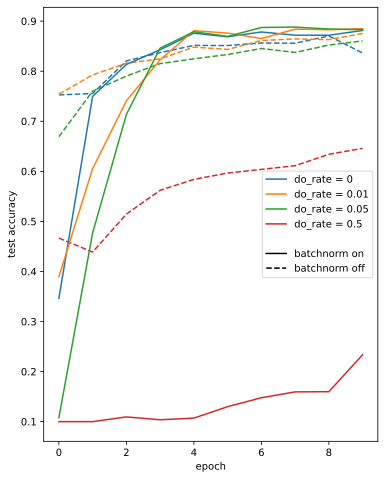

In [ ]:
# Plot the results
plt.figure(figsize=(6, 8), dpi=100)
color_cycle = iter(plt.rcParams['axes.prop_cycle'])

colors = {}

lines = []
labels = []
for config, model in models.items():
  config = eval(config)
  if config['dropout_rate'] not in colors:
    colors[config['dropout_rate']] = next(color_cycle)

  color = colors[config['dropout_rate']]['color']

  style = '-' if config['use_batchnorm'] else '--'
  line, = plt.plot(model.history.history['val_sparse_categorical_accuracy'], style,
                   c=color)
  
  if config['use_batchnorm']:
    lines.append(line)
    labels.append(f"do_rate = {config['dropout_rate']}")

plt.xlabel("epoch")
plt.ylabel("test accuracy");

from matplotlib.lines import Line2D

lines += [Line2D([0], [0], linestyle='-', color='w'),
          Line2D([0], [0], linestyle='-', color='k'),
          Line2D([0], [0], linestyle='--', color='k')]
labels += ['', 'batchnorm on', 'batchnorm off']
plt.legend(lines, labels);